## 8.6 Estimation and model selection
### Model selection
In the ETS statistical framework information criteria can be used for model selection, e.g. $AIC$, $AIC_c$, $BIC$. These can be used here to determine which of the ETS models is most appropriate for a given time series.

For ETS models, Akaike’s Information Criterion (AIC) is defined as
$$
AIC=−2\log(L)+2k,
$$
where $L$ is the likelihood of the model and kk is the total number of parameters and initial states that have been estimated (including the residual variance).

The AIC corrected for small sample bias ($\text{AIC}_c$) is defined as
$$
\text{AIC}_c=\text{AIC}+\frac{2k(k+1)}{T−k−1},
$$
and the Bayesian Information Criterion (BIC) is
$$
\text{BIC}=\text{AIC}+k[\log(T)−2].
$$

### Example: Domestic holiday tourist visitor nights in Australia
Use the ETS statistical framework to forecast Australian holiday tourism over the period 2016-2019.

In [1]:
import sys
sys.path.append('..')
from utils import *

In [11]:
tourism = (
    pd.read_csv('../data/tsibble/tourism.csv')
    .pipe(compute, lambda x: dict(
        date=pd.to_datetime(x.Quarter.str.replace(' ', ''))
    ))
)
aus_holidays = (
    tourism
    .query("Purpose == 'Holiday'")
    .groupby('date'.split())
    .Trips.sum()
    .reset_index()
    .set_index('date')
    .pipe(set_freq)
)
aus_holidays['Trips'] = aus_holidays['Trips']/1e3

Note that `statsmodels.tsa.statespace.exponential_smooth.ExponentialSmoothing` is **additive only**. It seems you have to explictly state that you want to include seasonality, it won't automatically do it for you in the optimisation process, unlike `ETS()` function in R. This means that you might have to manually examine the values of AIC and BIC to determine which of the 9 possibilities gives the best results.

In [6]:
from statsmodels.tsa.statespace.exponential_smoothing import ExponentialSmoothing

In [64]:
model = ExponentialSmoothing(endog=aus_holidays['Trips'], seasonal=4).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                  Trips   No. Observations:                   80
Model:                   ETS(A, N, A)   Log Likelihood                 -45.481
Date:                Thu, 21 Nov 2024   AIC                            104.962
Time:                        11:16:44   BIC                            121.636
Sample:                    01-01-1998   HQIC                           111.647
                         - 10-01-2017   Scale                            0.183
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3654      0.087      4.179      0.000       0.194       0.537
smoothing_seasonal      0.0001      0.096      0.001      0.999      -0.188       0.188
initial_level           9.8382      0.333     29.565      0.000       9.186      10.490
initial_seasonal       -0.5333      0.085     -6.257      0.000      -0.700      -0.366
initial_seasonal.L1    -0.6919      0.083     -8.360      0.000      -0.854      -0.530
initial_seasonal.L2    -0.3076      0.079     -3.903      0.000      -0.462      -0.153
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.50   Prob(JB):                         0.95
Heteroskedasticity (H):               2.07   Skew:                             0.08
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [68]:
model2 = ETSModel(endog=aus_holidays['Trips'], error='mul', seasonal='add', seasonal_periods=4).fit(disp=0)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                  Trips   No. Observations:                   80
Model:                       ETS(MNA)   Log Likelihood                 -44.347
Date:                Thu, 21 Nov 2024   AIC                            104.694
Time:                        11:19:49   BIC                            123.750
Sample:                    01-01-1998   HQIC                           112.334
                         - 10-01-2017   Scale                            0.002
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.3477      0.061      5.713      0.000       0.228       0.467
smoothing_seasonal  6.523e-05        nan        nan        nan         nan         nan
initial_level         11.2508        nan        nan        nan         nan         nan
initial_seasonal.0    -2.0579        nan        nan        nan         nan         nan
initial_seasonal.1    -2.2073        nan        nan        nan         nan         nan
initial_seasonal.2    -1.8123        nan        nan        nan         nan         nan
initial_seasonal.3          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                        6.57   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.58   Prob(JB):                         0.98
Heteroskedasticity (H):               1.88   Skew:                            -0.03
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

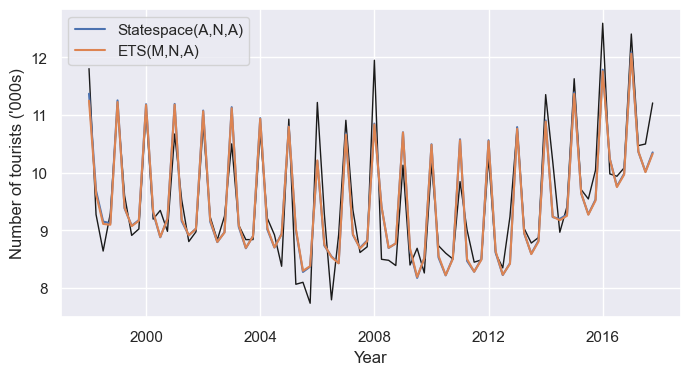

In [70]:
f, ax = plt.subplots(figsize=(8, 4))
ax.plot(aus_holidays['Trips'], 'k', linewidth=1)
ax.plot(model.fittedvalues, label='Statespace(A,N,A)')
ax.plot(model2.fittedvalues, label='ETS(M,N,A)')
ax.set(xlabel='Year', ylabel="Number of tourists ('000s)")
ax.legend()
plt.show()